<a href="https://colab.research.google.com/github/nikibhatt/DS-Unit-2-Applied-Modeling/blob/master/DS_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍔

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [0]:
train = train.dropna()
test = test.dropna()

### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [0]:
import pandas_profiling

profile_report = train.profile_report(
    check_correlation_pearson=False,
    correlations={
        'pearson': False,
        'spearman': False,
        'kendall': False,
        'phi_k': False,
        'cramers': False,
        'recoded': False,
    },
    plot={'histogram': {'bayesian_blocks_bins': False}},
)

profile_report


In [0]:
train.dropna()
test.dropna()

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [0]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(train, test_size=0.2)

In [108]:
train.shape, val.shape, test.shape

((41532, 17), (10384, 17), (17306, 17))

In [0]:
train.reset_index()
test.reset_index()
val.reset_index()

In [0]:
val.head()

In [130]:
# The status_group column is the target
target = 'Fail'

# Get a dataframe with all train columns except the target & id
#train_features = train.drop(columns=[target, 'Address', 'AKA_Name', 'DBA_Name', 'Inspection_Date', 'License_#' ], axis=1)
train_features = train.drop(columns=[target, 'Address'], axis=1)

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features
print(features)

['Inspection ID', 'License #', 'Zip', 'Latitude', 'Longitude', 'Risk', 'City', 'State', 'Inspection Type']


In [0]:
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

In [0]:
# Try Random Forest

from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators = 500, random_state = 42, n_jobs=-1)
)

In [113]:
# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

Validation Accuracy 0.7441255778120185


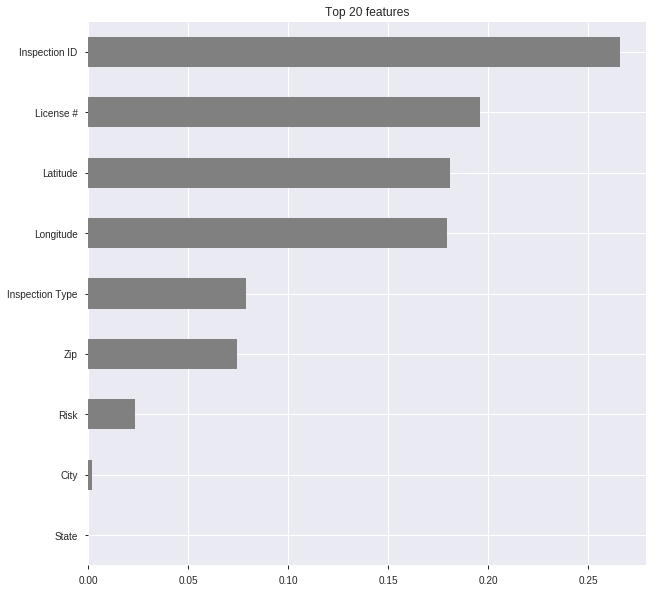

In [114]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [0]:
#Improve accuracy of RF model using XGBoost

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=500, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

In [0]:
#ROC AUC score

from sklearn.metrics import roc_auc_score

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=500, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

X_test_processed = processor.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) # Ranges from 0-1, higher is better

## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [132]:
#Visualization - 1

import eli5
from eli5.sklearn import PermutationImportance

# Random Forest outside of Pipeline for ELI5

transformers = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.transform(X_val)

model = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

# Permuter

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_val_transformed, y_val)

#visualize

feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None, # show permutation importances for all features
    feature_names=feature_names
)

Weight,Feature
0.0450 ± 0.0018,Inspection Type
0.0285 ± 0.0041,Inspection ID
0.0029 ± 0.0040,License #
0.0022 ± 0.0027,Risk
0.0004 ± 0.0029,Latitude
0 ± 0.0000,State
-0.0002 ± 0.0002,City
-0.0025 ± 0.0038,Longitude
-0.0036 ± 0.0046,Zip


In [0]:
#To improve the scores, remove columns not important as shown by Permuter

minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]
X_test = X_test[features]
X_val = X_val[features]

X_val = X_val[features]

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median'), 
    RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
print('Validation Accuracy', pipeline.score(X_val, y_val))

In [0]:
#Improve accuracy of RF model using XGBoost (after removing features)

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=500, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)


y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

In [0]:
#ROC AUC score (after removing features)


from sklearn.metrics import roc_auc_score

processor = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=500, n_jobs=-1)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

X_test_processed = processor.transform(X_test)
class_index = 1
y_pred_proba = model.predict_proba(X_test_processed)[:, class_index]
print(f'Test ROC AUC for class {class_index}:')
print(roc_auc_score(y_test, y_pred_proba)) # Ranges from 0-1, higher is better

In [0]:
#Visualization 2

from pdpbox.pdp import pdp_interact, pdp_interact_plot

In [0]:
# Model, outside of a pipeline

train = train.dropna()
test = test.dropna()

X = train[features]
y = train[target]

encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)


findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


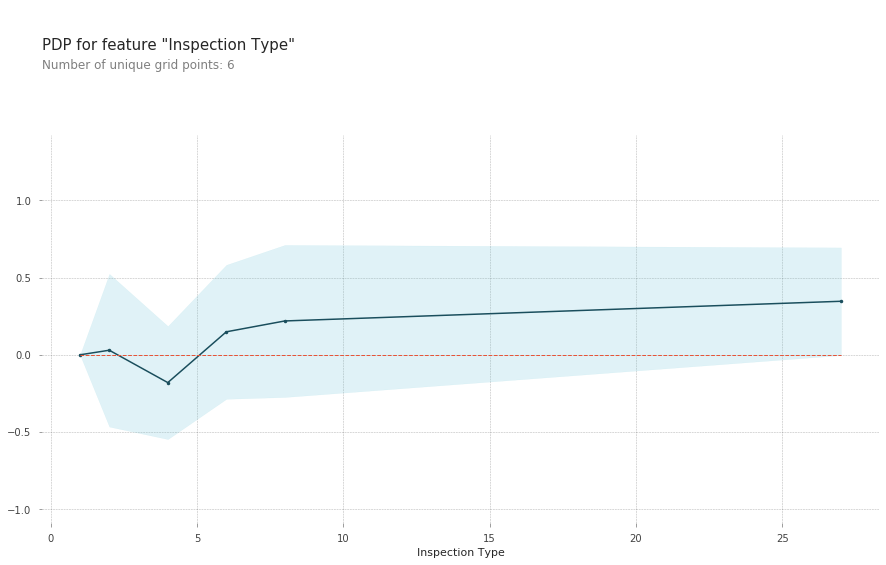

In [150]:
#PDP with one feature

%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp

feature = 'Inspection Type'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);


In [0]:
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

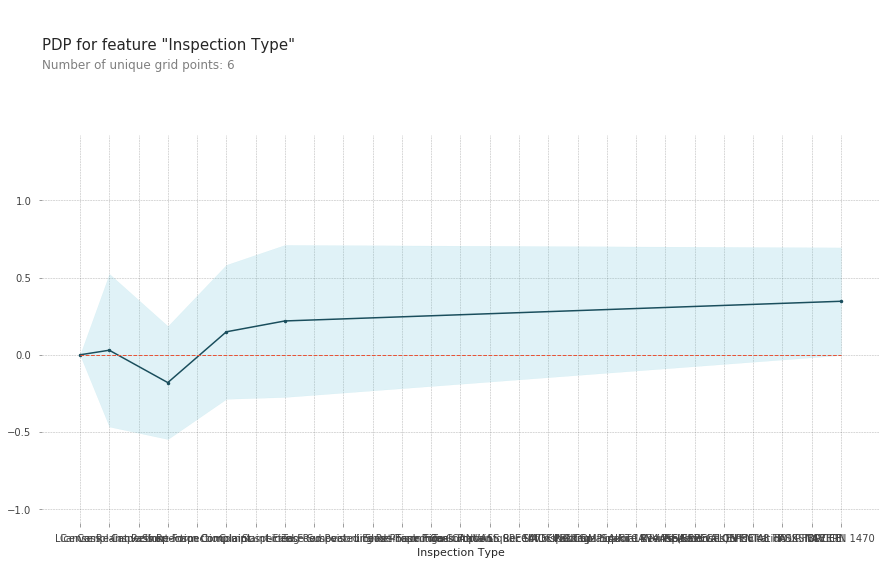

In [152]:
pdp.pdp_plot(pdp_dist, feature)

# Automatically change the xticks labels
plt.xticks(category_codes, category_names);

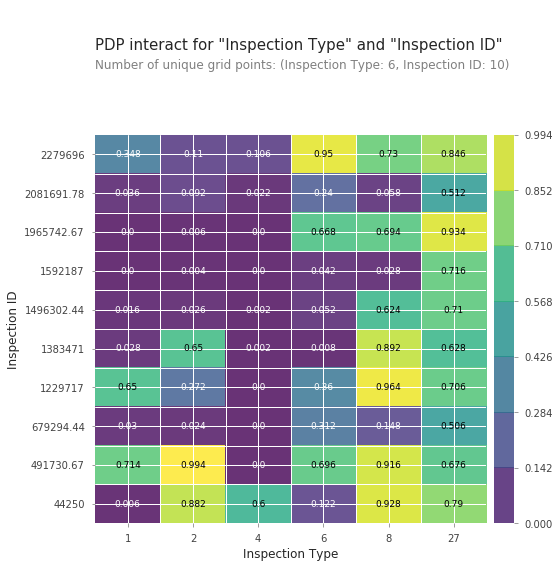

In [153]:
#PDP with two features

features = ['Inspection Type', 'Inspection ID']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

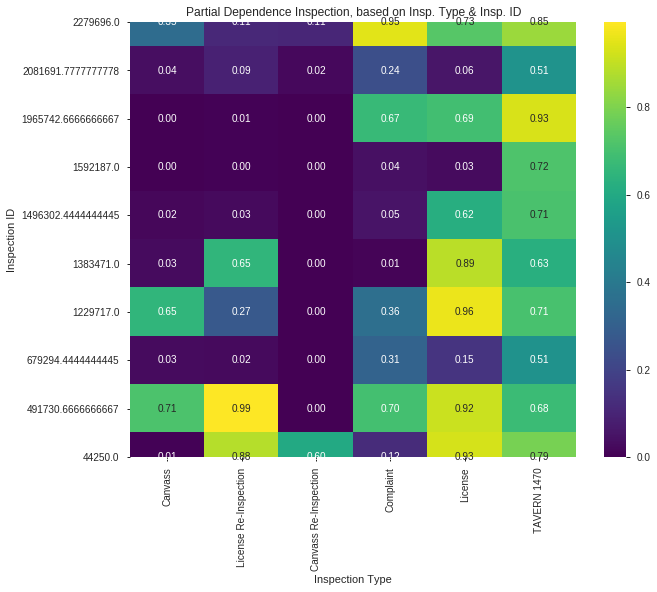

In [155]:
import seaborn as sns

pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], # First feature on x axis
    index=features[1]    # Next feature on y axis
)[::-1]  # Reverse the index order so y axis is ascending

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence Inspection, based on Insp. Type & Insp. ID');

In [157]:
X_test.tail(20)

,Inspection ID,License #,Zip,Latitude,Longitude,Risk,City,State,Inspection Type
17286,1932279,2031676.0,60618.0,41.939285,-87.697336,Risk 1 (High),CHICAGO,IL,Canvass
17287,491729,1145661.0,60620.0,41.735932,-87.645805,Risk 2 (Medium),CHICAGO,IL,Canvass
17288,1566466,2192852.0,60616.0,41.838164,-87.645549,Risk 1 (High),CHICAGO,IL,Canvass Re-Inspection
17289,1188291,82816.0,60625.0,41.975940,-87.697364,Risk 1 (High),CHICAGO,IL,Canvass Re-Inspection
17290,1307574,1649665.0,60629.0,41.764237,-87.720010,Risk 1 (High),CHICAGO,IL,Canvass
17291,1950860,2477169.0,60632.0,41.800404,-87.728122,Risk 2 (Medium),CHICAGO,IL,License
17292,1383469,1573767.0,60601.0,41.886006,-87.620829,Risk 1 (High),CHICAGO,IL,Canvass
17293,419507,1769266.0,60647.0,41.927879,-87.706925,Risk 1 (High),CHICAGO,IL,Canvass
17294,604522,2074607.0,60630.0,41.968559,-87.778072,Risk 1 (High),CHICAGO,IL,Canvass
17295,1296400,2215760.0,60617.0,41.728378,-87.549216,Risk 1 (High),CHICAGO,IL,License


In [166]:
# Shaply Plots


import shap

row = X_test.iloc[[17296]]

explainer = shap.TreeExplainer(model)
row_processed = processor.transform(row)
shap_values = explainer.shap_values(row_processed)
shap_values

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value[0], 
    shap_values=shap_values[0], 
    features=row, 
    #link='logit' # For classification, this shows predicted probabilities
)